## Filter bindingsites

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
path = Path('data')
dataset = 'LGG'
data_level = 'gene'#'exon'#
tcga_path = Path(path/dataset)
path_tarp = Path('../data')
path_input = Path('../data/all_cdna_subsets')

### Merge bindingsites filtered by elastic regression with TarPmiR bindingsites


In [21]:
#read in TarPmiR bindingsites
def read_in_tarp_bs(path):
    f = Path(path/'bs_tarp_subset_filtered_0.8.parquet')
    if f.is_file():
        bs_tarp = pd.read_parquet(f)
    else:
        bs_tarp = pd.read_parquet(path/'bs_tarp_subset_filtered.parquet') #here still binding probabilities 0.5-1
        bs_tarp = bs_tarp[bs_tarp.binding_probability > 0.8]
        bs_tarp.to_parquet(f)
    return bs_tarp

#visualize tarpmir binding sites
def plot_tarp_bs(bs_tarp):
    bs_tarp.groupby('miRNA')['exon_id'].agg('count').hist()
    plt.ylabel("Amount of miRNAs")
    plt.xlabel("Amount of exons that have target site per miRNA")
    plt.show()
    bs_tarp.groupby('exon_id')['miRNA'].agg('count').hist()
    plt.ylabel("Amount of exons")
    plt.xlabel("Amount of miRNAs that have target site per exon")
    plt.show()
    bs_tarp.groupby('ensembl_transcript_id')['miRNA'].agg('count').hist()
    plt.ylabel("Amount of transcripts")
    plt.xlabel("Amount of miRNAs that have target site per transcript")
    plt.show()
    bs_tarp.groupby('ensembl_gene_id')['miRNA'].agg('count').hist()
    plt.ylabel("Amount of genes")
    plt.xlabel("Amount of miRNAs that have target site per genes")
    plt.show()
    bs_tarp['binding_probability'].hist()
    plt.ylabel("Amount target sites")
    plt.xlabel("Binding probability")
    plt.show()

def is_bs_counts_in_bs_tarp(bs_counts, bs_tarp):
    bs_common = bs_counts[['mature_name','gene_id','exon_id','coefficient']].merge(bs_tarp, how='inner', left_on=['mature_name','gene_id'], right_on=['miRNA','ensembl_gene_id'],suffixes=['_counts', '_tarp']).drop(['mature_name','gene_id'],axis=1)
    #all combinations of exons per gene -> only if exon_id in exon_id
    bs_common['common'] = bs_common[['exon_id_tarp','exon_id_counts']].apply(lambda x: x.exon_id_tarp in x.exon_id_counts,axis=1)
    bs_common = bs_common[bs_common['common']]
    bs_common = bs_common.groupby(['miRNA','ensembl_gene_id','exon_id_counts','coefficient']).agg({'common':'first','exon_id_tarp':lambda x: list(x),'ensembl_transcript_id':lambda x: list(set(x)),'binding_probability':lambda x: list(x)})
    bs = bs_counts[['mature_name','gene_id','exon_id','coefficient']].rename({'exon_id':'exon_id_counts','mature_name':'miRNA','gene_id':'ensembl_gene_id'},axis=1)
    bs_common.reset_index(inplace=True)
    bs = pd.concat([bs,bs_common[['miRNA','ensembl_gene_id','exon_id_counts','coefficient']]]).drop_duplicates(keep=False,subset=['miRNA','exon_id_counts'])
    bs['common'] = False
    bs.reset_index(drop=True, inplace=True)
    bs_common['index'] = range(len(bs),len(bs)+len(bs_common))
    bs_common.set_index(bs_common['index'], inplace=True)
    bs_common = bs_common.drop('index',axis=1)
    bs = pd.concat([bs, bs_common])
    bs['binding'] = bs['coefficient'] < 0
    return bs #contains all bs_counts but with tarpmir information if available

f = Path(tcga_path/('bs_both_filtered_'+data_level+'.parquet'))
if f.is_file():
    bs = pd.read_parquet(f)
    print('read data from file')
else:
    #read in elastic regression filtered bindingsites
    bs_counts = pd.read_parquet(tcga_path/('bs_counts_filtered_'+data_level+'.parquet'))
    #read in TarPmiR bindingsites
    bs_tarp = read_in_tarp_bs(path)
    #plot_tarp_bs(bs_tarp)
    bs = is_bs_counts_in_bs_tarp(bs_counts, bs_tarp)
    bs.to_parquet(f)
print(f'{len(bs[bs.common])} common binding sites between all TarPmiR binding sites and the {len(bs)} {dataset} TCGA binding sites ({(len(bs[bs.common])/len(bs))*100:.2f}%).')

read data from file
25 common binding sites between all TarPmiR binding sites and the 204 LGG TCGA binding sites (12.25%).


Text(0.5, 0, 'Amount binding exons')

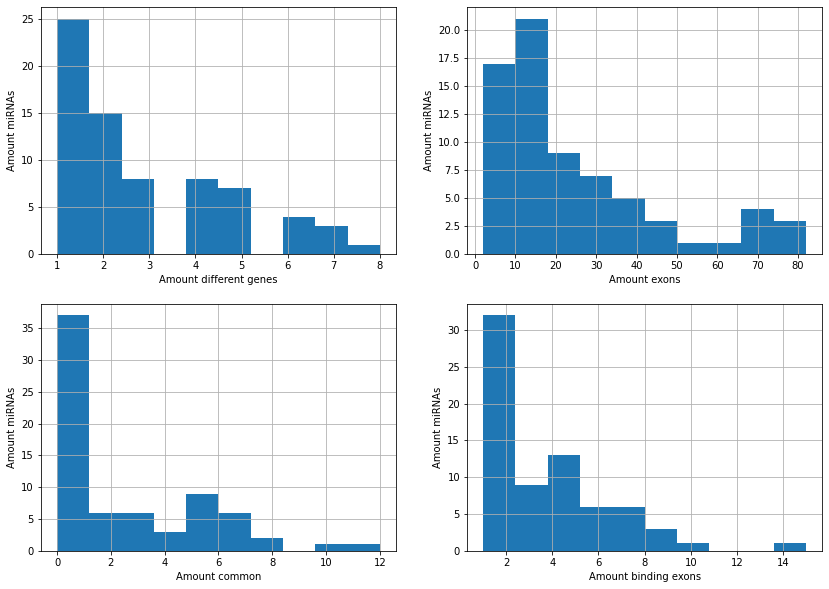

In [91]:
#plot histograms per mirna model
fig1, ax1 = plt.subplots(2, 2,figsize=(14,10))
bs['binding'] = bs['binding'].astype(int)
bs['common'] = bs['common'].astype(int)
mirna_level = bs.groupby('miRNA').agg({'binding':'sum','coefficient':(lambda x: list(x)),'common':'sum','ensembl_gene_id':(lambda x: len(set(x))),'exon_id_counts':'count','miRNA':'first'})
mirna_level['ensembl_gene_id'].hist(ax=ax1[0,0])
ax1[0,0].set_ylabel("Amount miRNAs")
ax1[0,0].set_xlabel("Amount different genes")
mirna_level['exon_id_counts'].hist(ax=ax1[0,1])
ax1[0,1].set_ylabel("Amount miRNAs")
ax1[0,1].set_xlabel("Amount exons")
mirna_level['common'].hist(ax=ax1[1,0])
ax1[1,0].set_ylabel("Amount miRNAs")
ax1[1,0].set_xlabel("Amount common")
mirna_level['binding'].hist(ax=ax1[1,1])
ax1[1,1].set_ylabel("Amount miRNAs")
ax1[1,1].set_xlabel("Amount binding exons")

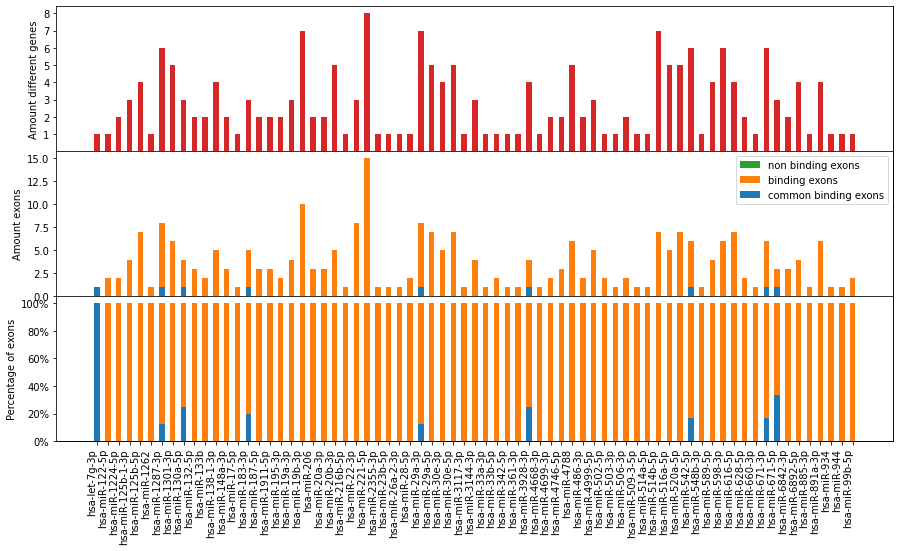

In [95]:
from matplotlib.ticker import PercentFormatter
import math
fig1, axs = plt.subplots(figsize=(15,8))
axs.set(xticks=[],yticks=[])
gs = fig1.add_gridspec(3, hspace=0)
(ax1,ax2,ax3) = gs.subplots(sharex=True)
mirna_level = bs.groupby('miRNA').agg({'binding':'sum','coefficient':(lambda x: list(x)),'common':'sum','ensembl_gene_id':(lambda x: len(set(x))),'exon_id_counts':'count','miRNA':'first'})
ax1.bar(mirna_level['ensembl_gene_id'].index,mirna_level['ensembl_gene_id'].values, color='tab:red',width=0.5)
ax1.set_ylabel('Amount different genes')
ax1.set_yticks(range(min(mirna_level['ensembl_gene_id'].values), max(mirna_level['ensembl_gene_id'].values)+1))
ax2.bar(mirna_level['exon_id_counts'].index,mirna_level['exon_id_counts'].values, color='tab:green',label='non binding exons',width=0.5)
ax2.bar(mirna_level['binding'].index,mirna_level['binding'].values, color='tab:orange',label='binding exons',width=0.5)
ax2.bar(mirna_level['common'].index,mirna_level['common'].values, color='tab:blue',label='common binding exons',width=0.5)
ax2.set_ylabel('Amount exons')
ax2.legend()
ax3.bar(mirna_level['exon_id_counts'].index,mirna_level['exon_id_counts'].values / mirna_level['exon_id_counts'].values, color='tab:green',label='non binding exons',width=0.5)
ax3.bar(mirna_level['binding'].index,mirna_level['binding'].values / mirna_level['exon_id_counts'].values, color='tab:orange',label='binding exons',width=0.5)
ax3.bar(mirna_level['common'].index,mirna_level['common'].values / mirna_level['exon_id_counts'].values, color='tab:blue',label='common binding exons',width=0.5)
ax3.set_ylabel('Percentage of exons')
ax3.yaxis.set_major_formatter(PercentFormatter(1))
ax3.set_xticks(ax3.get_xticks())
ax3.set_xticklabels(mirna_level.index,rotation=90, ha='right')
for ax in [ax1,ax2,ax3]:
    ax.label_outer()

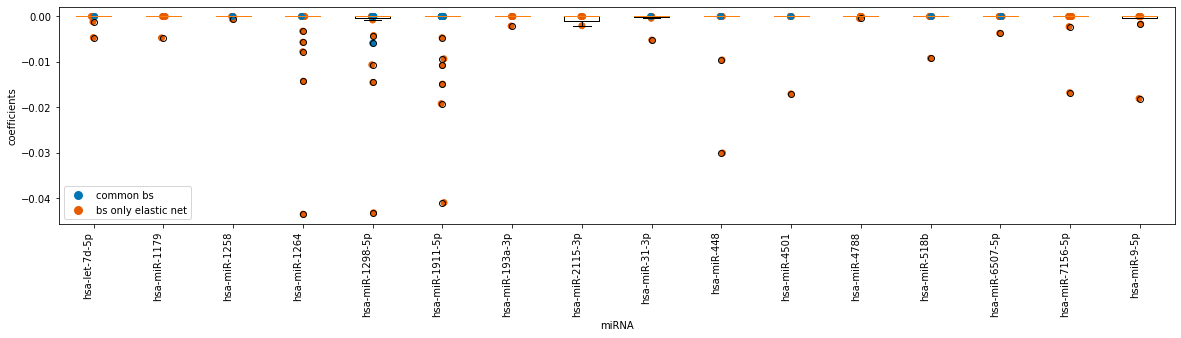

In [88]:
#plot coefficients per mirna | color by common or not
from matplotlib.lines import Line2D
from collections.abc import Iterable
fig1, ax1 = plt.subplots(figsize=(20,4))
mirna_level = bs.groupby('miRNA').agg({'binding':'sum','coefficient':(lambda x: list(x)),'common':(lambda x: list(x)),'ensembl_gene_id':(lambda x: len(set(x))),'exon_id_counts':'count','miRNA':'first'})
plt.xlabel('miRNA')
plt.ylabel('coefficients')
ax1.boxplot(mirna_level.coefficient.to_list())
ax1.set_xticklabels(mirna_level.miRNA, rotation=90, ha='right')
for i in range(len(mirna_level)):
    y = mirna_level.coefficient.to_list()[i]
    x = np.random.normal(1+i, 0.01, size=len(y))
    color_common = np.array([([0, 119, 179] if val else [230, 90, 0]) for val in mirna_level.common.to_list()[i]])/255.0
    ax1.scatter(x, y, c=color_common, marker='o')
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=np.array([0, 119, 179])/255.0, color='w',label='common bs', markersize=10),
                   Line2D([0], [0], marker='o', markerfacecolor=np.array([230, 90, 0])/255.0, color='w',label='bs only elastic net', markersize=10)]
plt.legend(handles = legend_elements)
plt.show()

<AxesSubplot:>

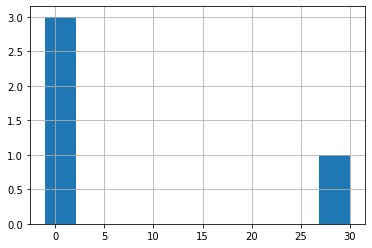

In [101]:
#bs['binding_probability'].hist()
#bs_counts['coefficient'].hist()
bs['coefficient'].hist()

### Analyse alternative splicing events

In [ ]:
#find interesting transcripts in Ensembl

#returns format {transcript_id : {exon_id : chromosome_start}}, {transcript_id : {exon_id : start}}, {transcript_id : {exon_id : end}}, pandas DataFrame [exon_id, transcript_id, chrom_exon_start, chrom_exon_end]
def calc_exon_data(path):
	feather_file = Path(path/'exon_info.feather')
	if feather_file.is_file():
		#load file from disk
		exon_info = pd.read_feather(feather_file)
	else:
		chrom_exon_starts = read_in_fasta(path/'all_exon_start.fasta')
		chrom_exon_ends = read_in_fasta(path/'all_exon_end.fasta')
		exon_info = {}
		for tid in chrom_exon_starts:
			sorted_ = {k: v for k, v in sorted(chrom_exon_starts[tid].items(), key=lambda item: item[1])}
			for eid in sorted_:
				chrom_exon_start = chrom_exon_starts[tid][eid]
				chrom_exon_end = chrom_exon_ends[tid][eid]
				exon_info[eid] = [tid, chrom_exon_start, chrom_exon_end]
				#write to disk
		exon_info = pd.DataFrame.from_dict(exon_info, orient='index', columns=['transcript_id','chrom_exon_start', 'chrom_exon_end']).reset_index()
		exon_info = exon_info.rename(columns={'index': "exon_id"})
		exon_info.to_feather(feather_file)
	return exon_info

def read_in_ensembl_exon_info(path):
    df_gene = pd.read_csv(path/'gene_infos.csv', dtype={'ensembl_gene_id':str,'ensembl_gene_id_version':str,'ensembl_transcript_id':str, 'ensembl_transcript_id_version':str, 'chromosome_name':'category', 'strand':'int8', 'start_position':int, 'end_position':int})
    del df_gene['Unnamed: 0']
    df_gene[['strand']] = df_gene[['strand']].astype('str').astype('category')
    df_exon = calc_exon_data(path) # exon starts and ends per transcript + exon id
    df_exon = df_exon.merge(df_gene, left_on = 'transcript_id', right_on = 'ensembl_transcript_id', how='left')
    df_exon[['chrom_exon_start','chrom_exon_end','start_position','end_position']] = df_exon[['chrom_exon_start','chrom_exon_end','start_position','end_position']].astype('Int64')
    df_exon['chromosome_name'] = df_exon['chromosome_name'].apply((lambda x: (x[4:] if x.startswith('CHR') else x)))
    df_exon[['strand']] = df_exon[['strand']].astype('str').astype('category')
    return df_exon

def nr_differing_exons(exon_id_x, exon_id_y):
    exons_x = exon_id_x.split(',')
    exons_y = exon_id_y.split(',')
    difference = list(list(set(exons_x)-set(exons_y)) + list(set(exons_y)-set(exons_x)))
    return len(difference)

def differing_exons(exon_id_x, exon_id_y):
    exons_x = exon_id_x.split(',')
    exons_y = exon_id_y.split(',')
    difference = list(list(set(exons_x)-set(exons_y)) + list(set(exons_y)-set(exons_x)))
    return ','.join(difference)

df_exon = read_in_ensembl_exon_info(path)[['exon_id','transcript_id','ensembl_gene_id']]
transcripts = df_exon.groupby(['ensembl_gene_id','transcript_id'], as_index=False).agg({'exon_id': (lambda x:','.join(set(x.astype(str))))})
per_gene = transcripts.groupby(['ensembl_gene_id'], as_index=False).agg({'transcript_id': (lambda x: x.count() > 1)}).rename({'transcript_id':'more_than_1_transcript'},axis=1)
print(f'{len(df_exon)} exons, {len(transcripts)} transcripts, {len(per_gene)} genes in Ensembl.')
transcripts = transcripts.merge(per_gene,how='inner',on='ensembl_gene_id')
transcripts = transcripts[transcripts.more_than_1_transcript].drop('more_than_1_transcript',axis=1)
print(f'{len(transcripts)} of transcripts are result of AS (gene has another transcript).')
per_trans = transcripts.merge(transcripts,on=['ensembl_gene_id'],how='inner') #all combinations of transcripts in a gene besides with itself
per_trans = per_trans[per_trans.transcript_id_x != per_trans.transcript_id_y]
per_trans['nr_differing_exons'] = per_trans[['exon_id_x','exon_id_y']].apply(lambda x: nr_differing_exons(x.exon_id_x,x.exon_id_y),axis=1)
per_trans['differing_exon'] = per_trans[['exon_id_x','exon_id_y']].apply(lambda x: differing_exons(x.exon_id_x,x.exon_id_y),axis=1)
#per_trans = per_trans[per_trans.nr_differing_exons == 1].drop('nr_differing_exons',axis=1)
#print(f'There are {len(per_trans)} interesting pairs of transcripts with all same exons besides one.')
per_trans.nr_differing_exons.hist()
per_trans.head()